In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import os
import numpy as np


In [3]:
# Compas data files
train = os.path.join(os.getcwd()+"/data/compas/train.csv")
test = os.path.join(os.getcwd()+"/data/compas/test.csv")
mean_std = os.path.join(os.getcwd()+"/data/compas/mean_std.json")
vocab = os.path.join(os.getcwd()+"/data/compas/vocabulary.json")

In [28]:
# Training hyperparams: where specified, we are using defaults from paper
BATCH_SIZE = 32 # Default from paper
PRIMARY_HIDDEN_UNITS = [64, 32]
# Second hidden layer has more neurons to make up for extra capacity in Adversarial model
BASELINE_HIDDEN_UNITS = [64, 64] 
ADVERSARY_HIDDEN_UNITS = 32
ACTIVATION = "relu"
OPTIMIZER = "Adagrad" # Default from paper
LEARNING_RATE = 0.01 # Default from paper was 0.001, we found a higher learning rate gives better overall results
AUC_NUM_THRESHOLDS=10 # Default from paper
TRAIN_STEPS = 20 # Default from paper
PRETRAIN_STEPS = 250 # Default from paper

# Protected groups feature values
BLACK = 0  
FEMALE = 0

In [5]:
from data_utils.compas_input import CompasInput

dataset = CompasInput(train_file=train,test_file=test,
                      mean_std_file=mean_std, vocab_file=vocab, 
                      protected_column_values=[FEMALE, BLACK])

# This takes about 2 minutes
X_train, y_train = dataset.get_data(mode="train", include_protected_columns = False)
X_test, y_test = dataset.get_data(mode="test", include_protected_columns = False)


In [6]:
# Get test sets for protected groups to test respective AUCs and assess fairness of model
X_test_protected, y_test_protected = dataset.get_data(mode="test", include_protected_columns = True)
X_test_female, y_test_female = X_test_protected[np.where(X_test_protected[:,0] == FEMALE)], y_test_protected[np.where(X_test_protected[:,0] == FEMALE)]
X_test_black, y_test_black = X_test_protected[np.where(X_test_protected[:,1] == BLACK)], y_test_protected[np.where(X_test_protected[:,1] == BLACK)]

# Remove protected cols since model is not expecting them
X_test_female = np.delete(X_test_female, [0,1], axis=1)
X_test_black = np.delete(X_test_black, [0,1], axis=1)

# Create dataset of both protected groups
X_test_female_black = tf.concat((X_test_female, X_test_black), axis=0)
y_test_female_black = tf.concat((y_test_female, y_test_black), axis=0)


In [45]:
# Set up features for adversarial model
# Concat the labels onto the features
X_train_adversarial = tf.concat((X_train, y_train), axis=1)


In [60]:
# Define the custom optimizer
if OPTIMIZER == "Adagrad":
    primary_optimizer = tf.keras.optimizers.Adagrad(LEARNING_RATE)
    adversary_optimizer = tf.keras.optimizers.Adagrad(LEARNING_RATE)
elif OPTIMIZER == "Adam":
    primary_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
    adversary_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

else:
    print("Define another optimizer")

In [61]:
from models import model_definitions

# Instantiate ARL models
primary_model = model_definitions.make_primary_model(X_train.shape[1], PRIMARY_HIDDEN_UNITS, ACTIVATION)
adversarial_model = model_definitions.make_adversarial_model(X_train_adversarial.shape[1], ADVERSARY_HIDDEN_UNITS, ACTIVATION)

# Instantiate baseline model
baseline_model = model_definitions.make_baseline_model(X_train.shape[1], BASELINE_HIDDEN_UNITS, ACTIVATION)


In [62]:
from train_models import train_baseline_model
from train_models import train_ARL_model

In [63]:
# Train baseline model for same amount of steps as ARL model
train_steps = PRETRAIN_STEPS+TRAIN_STEPS
baseline_model_trained = train_baseline_model.train(baseline_model, 
                            X_train, 
                            y_train, 
                            train_steps, 
                            primary_optimizer,
                            BATCH_SIZE)

Training baseline model...
Training step:  0
Training accuracy:  0.47514358
Training step:  10
Training accuracy:  0.48702714
Training step:  20
Training accuracy:  0.5508021
Training step:  30
Training accuracy:  0.5684294
Training step:  40
Training accuracy:  0.59615767
Training step:  50
Training accuracy:  0.61616164
Training step:  60
Training accuracy:  0.62428206
Training step:  70
Training accuracy:  0.62606454
Training step:  80
Training accuracy:  0.62943155
Training step:  90
Training accuracy:  0.634185
Training step:  100
Training accuracy:  0.6329966
Training step:  110
Training accuracy:  0.63814616
Training step:  120
Training accuracy:  0.63814616
Training step:  130
Training accuracy:  0.64230543
Training step:  140
Training accuracy:  0.64250344
Training step:  150
Training accuracy:  0.6419093
Training step:  160
Training accuracy:  0.64230543
Training step:  170
Training accuracy:  0.6432957
Training step:  180
Training accuracy:  0.64309764
Training step:  190
Tr

In [64]:
# Train ARL model
primary_model_trained, adversarial_model_trained = train_ARL_model.train(primary_model, 
                      adversarial_model, 
                      X_train, 
                      X_train_adversarial, 
                      y_train, 
                      PRETRAIN_STEPS, 
                      TRAIN_STEPS,
                      primary_optimizer,
                      adversary_optimizer,
                      BATCH_SIZE)


Pre-training primary model...
Training step:  0
Training accuracy:  0.5521886
Training step:  10
Training accuracy:  0.56327987
Training step:  20
Training accuracy:  0.5650624
Training step:  30
Training accuracy:  0.5836799
Training step:  40
Training accuracy:  0.6022975
Training step:  50
Training accuracy:  0.6165577
Training step:  60
Training accuracy:  0.6234898
Training step:  70
Training accuracy:  0.6288374
Training step:  80
Training accuracy:  0.6324025
Training step:  90
Training accuracy:  0.6331947
Training step:  100
Training accuracy:  0.63279855
Training step:  110
Training accuracy:  0.6337889
Training step:  120
Training accuracy:  0.6335908
Training step:  130
Training accuracy:  0.6351753
Training step:  140
Training accuracy:  0.63755196
Training step:  150
Training accuracy:  0.64072096
Training step:  160
Training accuracy:  0.644286
Training step:  170
Training accuracy:  0.6440879
Training step:  180
Training accuracy:  0.64369184
Training step:  190
Trainin

In [71]:
# BASELINE MODEL RESULTS

print("BASELINE MODEL RESULTS")
print("Train Accuracy")
acc = tf.keras.metrics.Accuracy()
class_predictions = tf.cast(tf.greater(baseline_model_trained(X_train), 0.5), tf.float32)
acc.update_state(class_predictions, y_train)
print(acc.result().numpy())


print("Test Accuracy")
acc = tf.keras.metrics.Accuracy()
class_predictions = tf.cast(tf.greater(baseline_model_trained(X_test), 0.5), tf.float32)
acc.update_state(class_predictions, y_test)
print(acc.result().numpy())

auc = tf.keras.metrics.AUC(
    num_thresholds=AUC_NUM_THRESHOLDS, curve='ROC')
class_predictions = tf.cast(tf.greater(baseline_model_trained(X_test), 0.5), tf.float32)
auc.update_state(class_predictions, y_test)
print("Test AUC(avg)")
print(auc.result().numpy())

auc = tf.keras.metrics.AUC(
    num_thresholds=AUC_NUM_THRESHOLDS, curve='ROC')
print("test AUC(min)")
class_predictions = tf.cast(tf.greater(baseline_model_trained(X_test_female_black), 0.5), tf.float32)
auc.update_state(class_predictions, y_test_female_black)
print(auc.result().numpy())


auc = tf.keras.metrics.AUC(
    num_thresholds=AUC_NUM_THRESHOLDS, curve='ROC')
print("Test AUC(minority) (female, since it is the smallest protected group) ")
class_predictions = tf.cast(tf.greater(baseline_model_trained(X_test_female), 0.5), tf.float32)
auc.update_state(class_predictions, y_test_female)
print(auc.result().numpy())

auc_female = auc.result().numpy()

auc = tf.keras.metrics.AUC(
    num_thresholds=AUC_NUM_THRESHOLDS, curve='ROC')
print("test AUC(black) (paper didn't do this but we are curious)")
class_predictions = tf.cast(tf.greater(baseline_model_trained(X_test_black), 0.5), tf.float32)
auc.update_state(class_predictions, y_test_black)
print(auc.result().numpy())
auc_black = auc.result().numpy()

print("Test AUC(macro-avg)")
print((auc_female + auc_black)/2)



BASELINE MODEL RESULTS
Train Accuracy
0.6456724
Test Accuracy
0.6554273
Test AUC(avg)
0.6772892
test AUC(min)
0.678404
Test AUC(minority) (female, since it is the smallest protected group) 
0.63603747
test AUC(black) (paper didn't do this but we are curious)
0.68244535
Test AUC(macro-avg)
0.6592414379119873


In [70]:
# ARL MODEL RESULTS

print("ARL MODEL RESULTS")
print("Train Accuracy")
acc = tf.keras.metrics.Accuracy()
class_predictions = tf.cast(tf.greater(primary_model_trained(X_train), 0.5), tf.float32)
acc.update_state(class_predictions, y_train)
print(acc.result().numpy())

print("Test Accuracy")
acc = tf.keras.metrics.Accuracy()
class_predictions = tf.cast(tf.greater(primary_model_trained(X_test), 0.5), tf.float32)
acc.update_state(class_predictions, y_test)
print(acc.result().numpy())

auc = tf.keras.metrics.AUC(
    num_thresholds=AUC_NUM_THRESHOLDS, curve='ROC')
class_predictions = tf.cast(tf.greater(primary_model_trained(X_test), 0.5), tf.float32)
auc.update_state(class_predictions, y_test)
print("Test AUC(avg)")
print(auc.result().numpy())

auc = tf.keras.metrics.AUC(
    num_thresholds=AUC_NUM_THRESHOLDS, curve='ROC')
print("Test AUC(min)")
class_predictions = tf.cast(tf.greater(primary_model_trained(X_test_female_black), 0.5), tf.float32)
auc.update_state(class_predictions, y_test_female_black)
print(auc.result().numpy())

auc = tf.keras.metrics.AUC(
    num_thresholds=AUC_NUM_THRESHOLDS, curve='ROC')
print("Test AUC(minority) (female, since it is the smallest protected group)")
class_predictions = tf.cast(tf.greater(primary_model_trained(X_test_female), 0.5), tf.float32)
auc.update_state(class_predictions, y_test_female)
print(auc.result().numpy())

auc_female = auc.result().numpy()

auc = tf.keras.metrics.AUC(
    num_thresholds=AUC_NUM_THRESHOLDS, curve='ROC')
print("Test AUC(black) (paper didn't show this but we are curious)")
class_predictions = tf.cast(tf.greater(primary_model_trained(X_test_black), 0.5), tf.float32)
auc.update_state(class_predictions, y_test_black)
print(auc.result().numpy())
auc_black = auc.result().numpy()

print("Test AUC(macro-avg)")
print((auc_female + auc_black)/2)


ARL MODEL RESULTS
Train Accuracy
0.6533967
Test Accuracy
0.6674365
Test AUC(avg)
0.67972535
Test AUC(min)
0.6867819
Test AUC(minority) (female, since it is the smallest protected group)
0.6455974
Test AUC(black) (paper didn't show this but we are curious)
0.6899953
Test AUC(macro-avg)
0.6677963733673096


In [76]:
# Results (averaged over 5 model runs)
# More analysis of results and discussion are included in the report

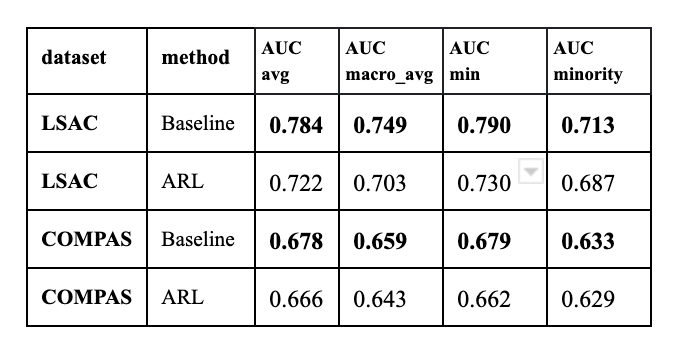